In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [2]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_주택가격/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_주택가격/test.csv')
sample_submission = pd.read_csv('C:/Users/KIHyuk/Desktop/dacon_data/Kaggle_주택가격/sample_submission.csv')

In [3]:
train_copy = train.copy()

print(train.shape)

print("전체 피처의 type \n",train_copy.dtypes.value_counts())

isnull_series = train_copy.isnull().sum()
print("\nNull 컬럼과 그 건수 : \n",isnull_series[isnull_series > 0].sort_values(ascending=False))

(1460, 81)
전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [4]:
train_copy.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


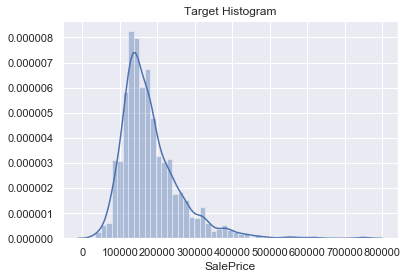

In [5]:
# target 분포 확인
plt.title("Target Histogram")
sns.distplot(train_copy['SalePrice'])

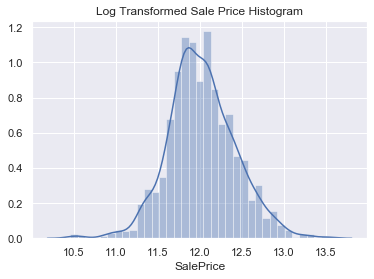

In [6]:
# 정규분포가 아닌 target값을 log변환 

plt.title("Log Transformed Sale Price Histogram")
log_target = np.log1p(train_copy['SalePrice'])
sns.distplot(log_target)

In [7]:
# null값 많은 컬럼 삭제
train_copy.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)

# drop하지 않은 숫자형 컬럼의 Null값은 평균값으로 대체
train_copy.fillna(train_copy.mean(),inplace=True)

# target log변환 적용
train_copy['SalePrice'] = np.log1p(train_copy['SalePrice'])

In [8]:
# 문자형 피처 원-핫인코딩
# 문자형 피처 원-핫인코딩 변환 시 Null값은 자동으로 "None"컬럼으로 대체해줌.

train_copy_ohe = pd.get_dummies(train_copy) # 피처 수 75에서 271로 증가

In [12]:
# 평가함수
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'로그 변환된 RMSE:',np.round(rmse,3))
    return rmse

# 여러모델 넣을때
def get_rmses(models): 
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [13]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = train_copy_ohe['SalePrice']
X_features = train_copy_ohe.drop('SalePrice',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.2,random_state=156)

# LinearRegrssion,Ridge,Lasso 학습,예측,평가
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154372, 0.12750846334053045, 0.17628250556471395]

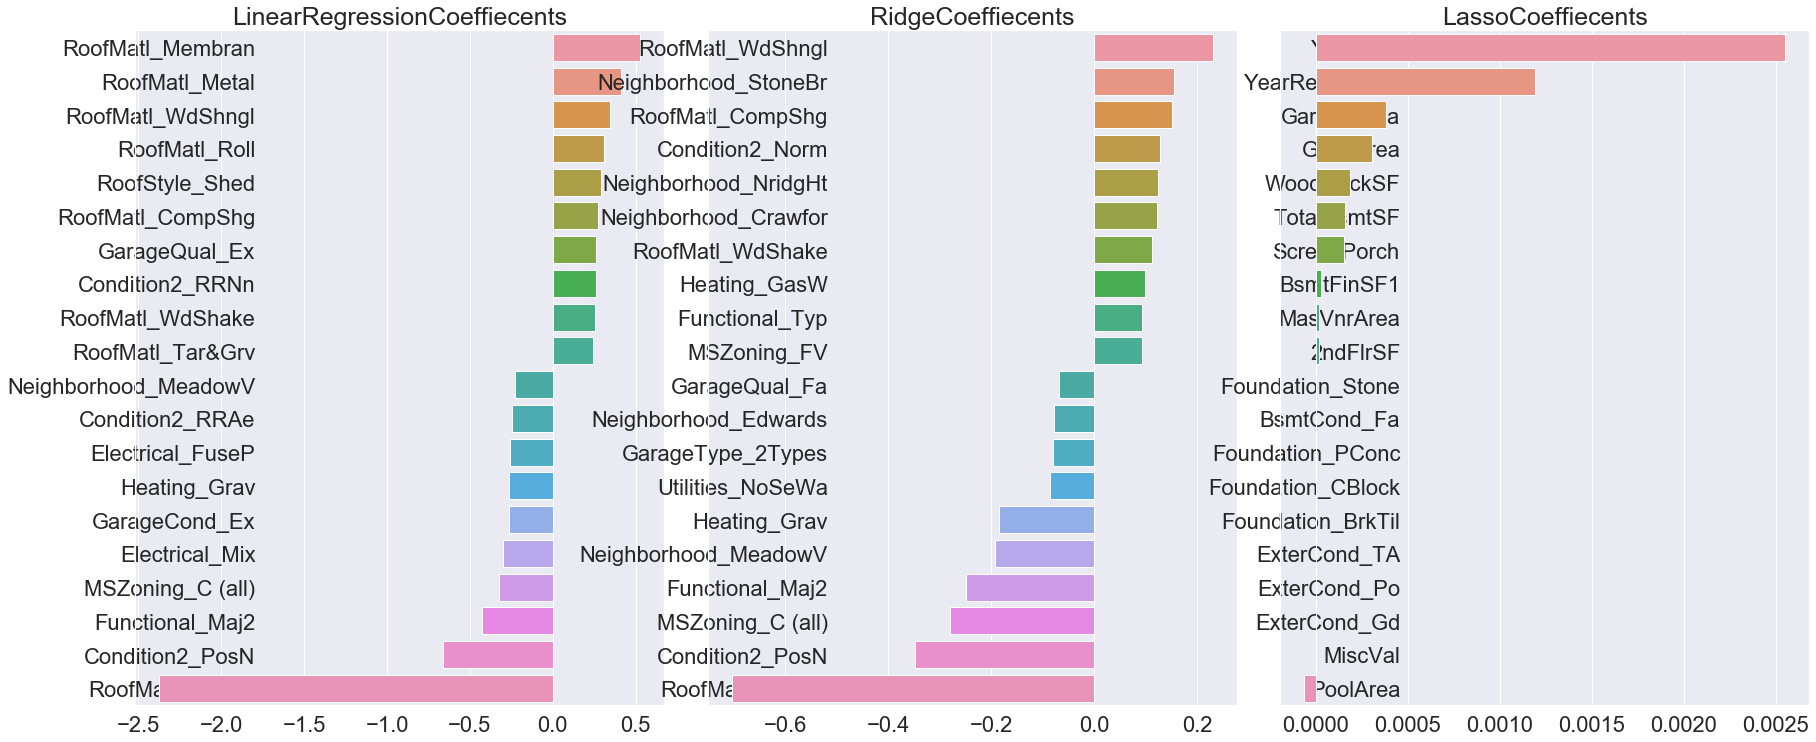

In [14]:
# 모델별 피처 회귀계수 

def get_top_bottom_coef(model,n=10):
    #coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high,coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot생성
    fig,axs = plt.subplots(figsize=(24,10),nrows=1,ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num,model in enumerate(models):
        #상위10개,하위10개 회귀계수를 구하고 이를 concat
        coef_high,coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high,coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표기하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecents',size=25)
        axs[i_num].tick_params(axis='y',direction='in',pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
# lr_reg,ridge_reg,lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

In [12]:
## 모델별 최적화 하이퍼 파라미터 작업 함수
from sklearn.model_selection import GridSearchCV

def print_best_params(model,params):
    grid_model = GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features,y_target) # train/test split 안나누고 
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print("{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}".format(model.__class__.__name__,np.round(rmse,4),
                                                            grid_model.best_params_))
    
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


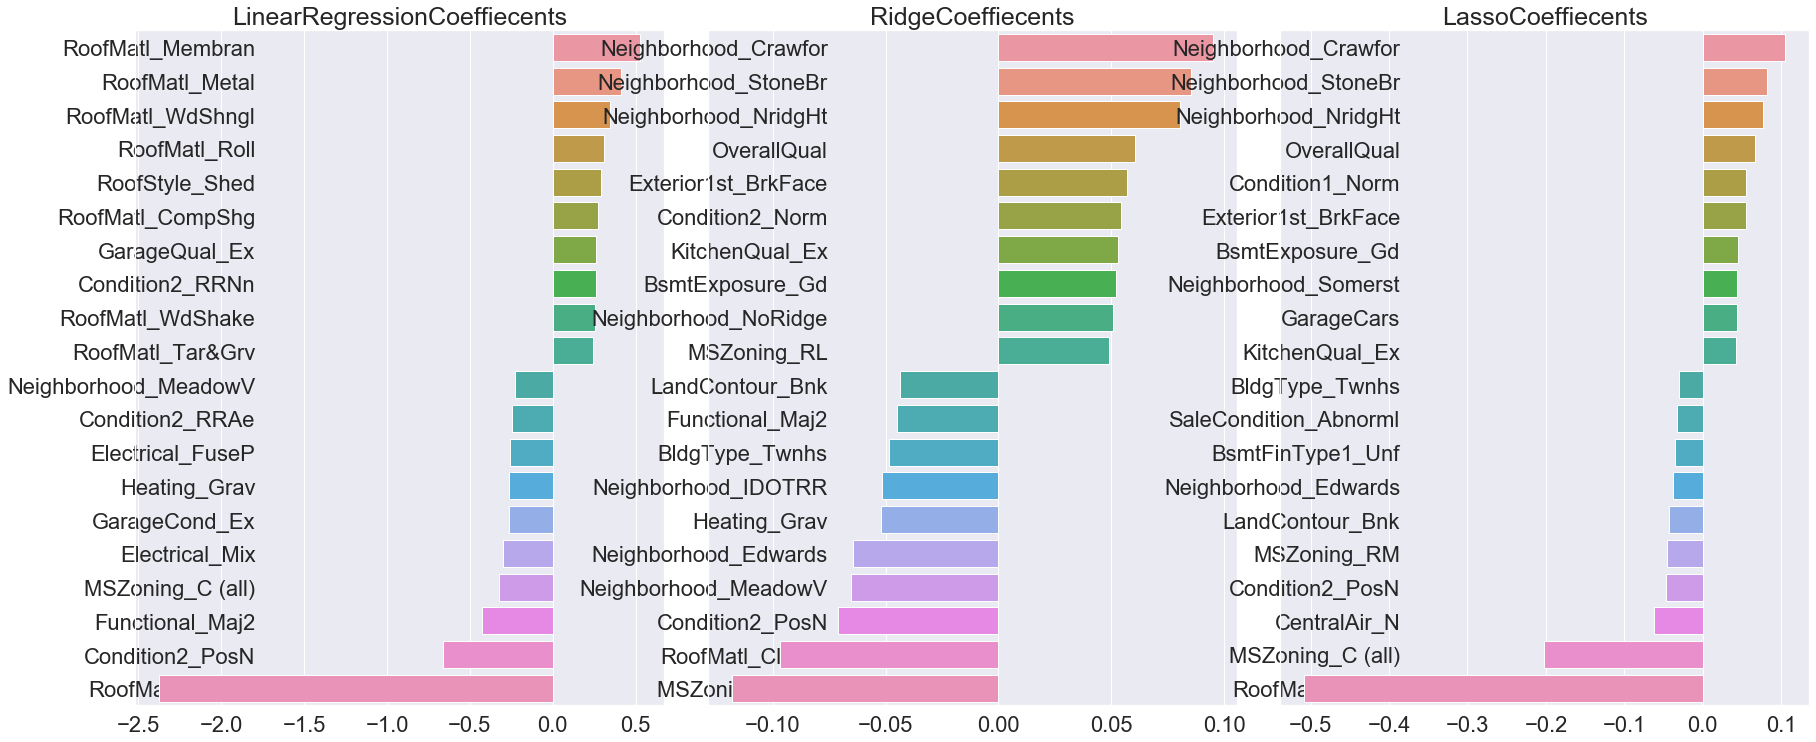

In [13]:
# 최적 하이퍼파라미터로 다시 학습/테스트
# train/test로

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

## 피처데이터의 분포와 이상치 처리

In [14]:
# scipy stats의 skew() 모듈 사용하요 왜곡 정도 구함

from scipy.stats import skew

# 숫자형 피처의 컬럼 index 추출 # 단, 원핫인코딩 되어있는 컬럼은 제외
features_index = train_copy.dtypes[train_copy.dtypes != 'object'].index

# train_copy에 컬럼 index를 []로 입력하면 해당하는 컬럼 데이터 세트 반환 .apply lambda로 skew() 호출
skew_features = train_copy[features_index].apply(lambda x : skew(x))

# skew(왜곡)정도가 1 이상인 컬럼만 추출
# SalePrice 컬럼은 위에서 이미 로그변환 완료 (train_copy에)
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [15]:
# 추출된 왜곡정도가 높은 피처를 로그 변환
train_copy[skew_features_top.index] = np.log1p(train_copy[skew_features_top.index])

In [16]:
# 피처 로그변환 후 다시 원핫인코딩 데이터셋 -> train/test -> 학습

train_copy_ohe = pd.get_dummies(train_copy)

y_target = train_copy_ohe['SalePrice']
X_features = train_copy_ohe.drop('SalePrice',axis=1,inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_features, y_target, test_size=0.2,random_state=156)

# 다시 최적 하이퍼파라미터 찾음
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

# train/test 안나뉜 X_features,y_target으로 그리드서치한 결과임
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


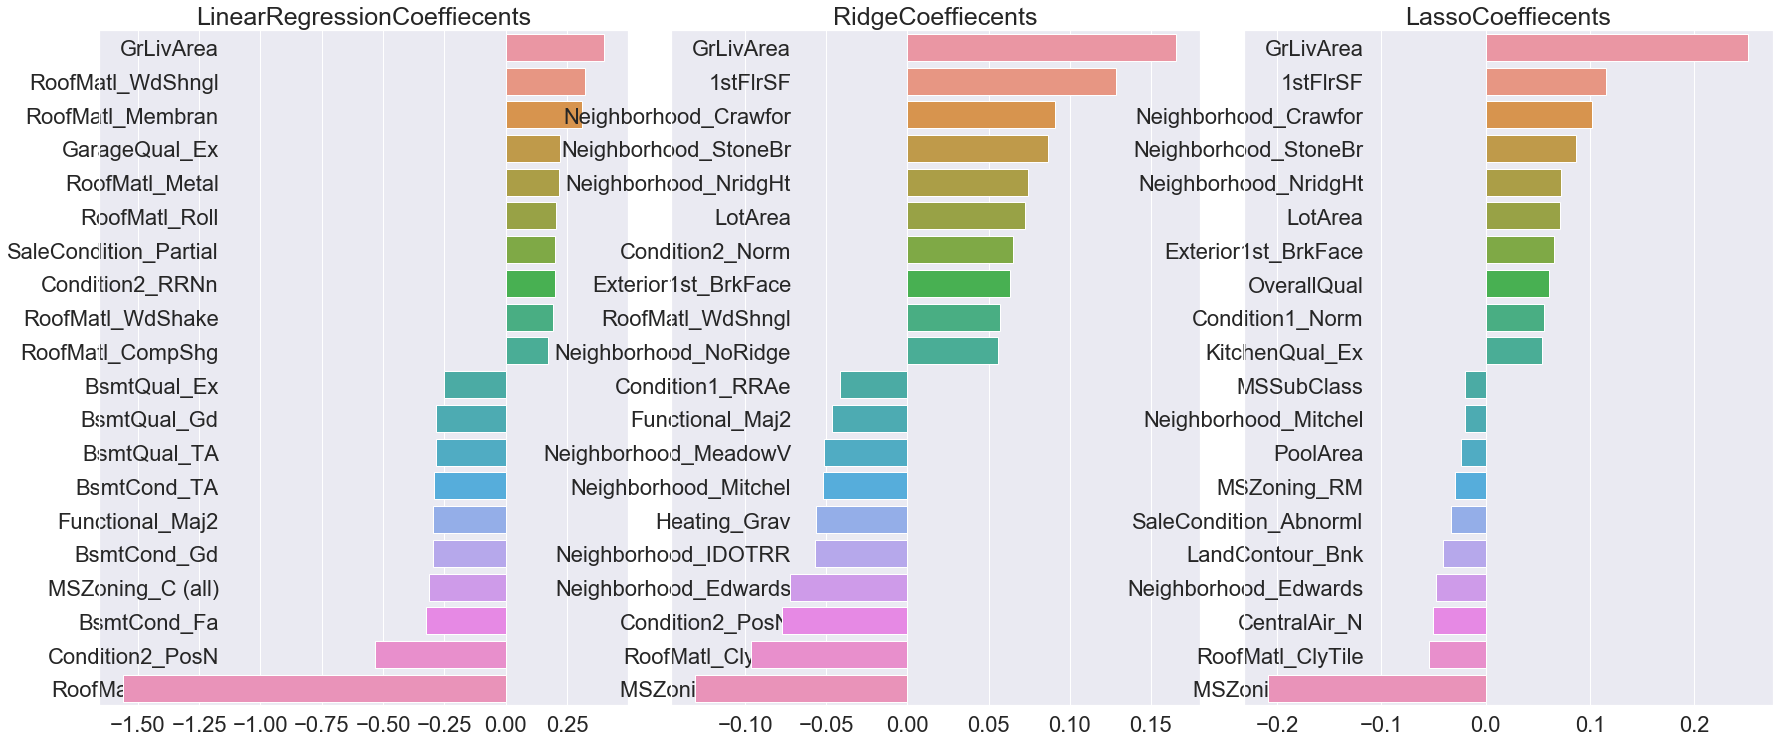

In [17]:
# 최적 하이퍼파라미터로 다시 학습/테스트
# train/test로

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

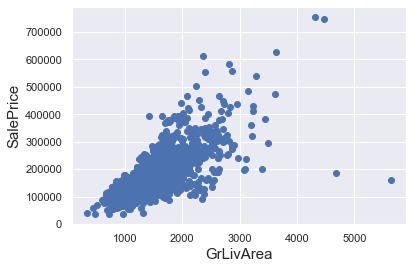

In [19]:
# 이상치 데이터 

# 3개 모델 모두에서 가장 높은 회귀계수를 가지는 GrLivArea 변수 
# 원본데이터에서 탐색
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea',fontsize=15)
plt.show()

# 이상치 데이터 존재 (2개)

In [20]:
# 이상치데이터 필터링
# train_copy_ohe 에서 진행

# 조건생성
cond1 = train_copy_ohe['GrLivArea'] > np.log1p(4000)
cond2 = train_copy_ohe['SalePrice'] < np.log1p(500000)
outlier_index = train_copy_ohe[cond1 & cond2].index

print('이상치 레코드 index : ',outlier_index.values)
#이상치 삭제
train_copy_ohe.drop(outlier_index,axis=0,inplace=True)

이상치 레코드 index :  [ 523 1298]


In [21]:
# 이상치 삭제한 데이터로 다시 진행
y_target = train_copy_ohe['SalePrice']
X_features = train_copy_ohe.drop('SalePrice',axis=1,inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_features, y_target, test_size=0.2,random_state=156)

# 다시 최적 하이퍼파라미터 찾음
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

# train/test 안나뉜 X_features,y_target으로 그리드서치한 결과임
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


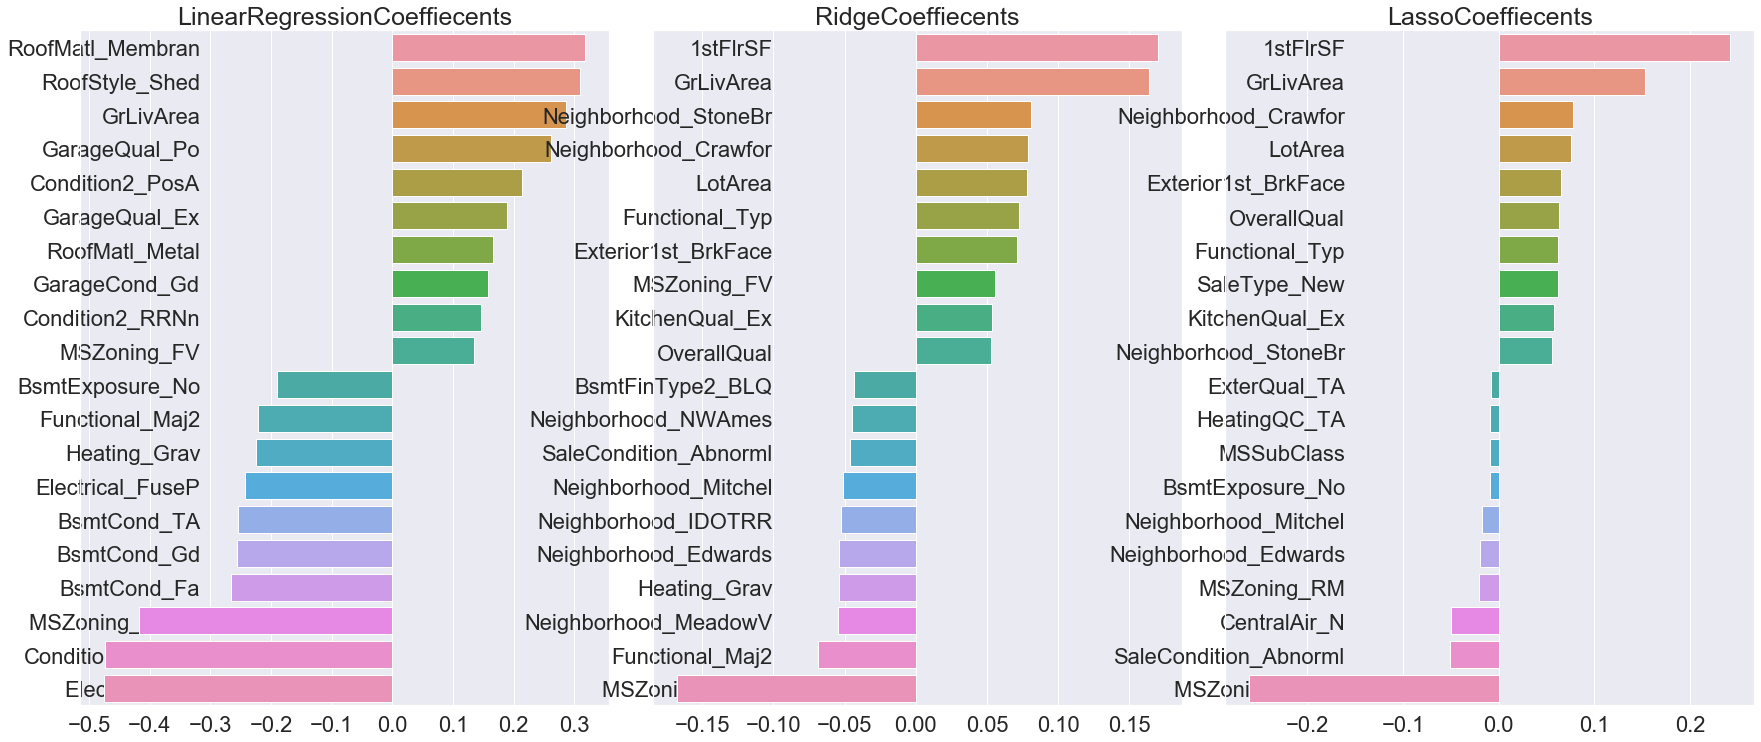

In [22]:
# 최적 하이퍼파라미터로 다시 학습/테스트
# train/test로

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

## 회귀 트리 모델 학습/예측/평가

In [23]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5,subsample=0.8)
print_best_params(xgb_reg,xgb_params)

[14:29:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:30:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.115, 최적 alpha:{'n_estimators': 1000}


In [24]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimator':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,subsample=0.6,
                        colsample_bytree=0.4,reg_lambda=10,n_jobs=1)
print_best_params(lgbm_reg,lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.1165, 최적 alpha:{'n_estimator': 1000}


## 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [28]:
# 개별 모델의 RMSE갑을 출력하는 함수
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test,pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE:{1}'.format(key,rmse))
        
# 개별 모델 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합':pred,
        'Ridge':ridge_pred,
        'Lasso':lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE:0.10007930884470519
Ridge 모델의 RMSE:0.10345177546603272
Lasso 모델의 RMSE:0.10024170460890039
